In [1]:
import importlib
import time
import os
import pickle
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
load_data = False

In [6]:
N_Z = 960
K = 32
I = 12
# F = float(15)
# b = float(10)
# c = float(2.5)

# F = float(14)
# b = float(4)
# c = float(2.5)

F = float(14)
b = float(1)
c = float(.37)

alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)

coarse = 8
N_Xc = N_Z//coarse
K_c = K//coarse

N_eZ = 100
save_dir = 'LM3_error_growth_cycle2'
home = os.path.expanduser('~')
save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)


dt_rk = 0.05/24

T_ic = 50

T_cycle = 8
N_cycle = 100

T_gt = T_cycle*N_cycle

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
this_path = os.path.join(save_dir, 't_gt.npy')
if load_data:
    t_gt = np.load(this_path)
else:
    t_gt = np.linspace(0, T_gt, int(T_gt/dt_rk) + 1)
    np.save(this_path, t_gt)

In [7]:
this_path = os.path.join(save_dir, 'Z_GT.npy')
if load_data:
    Z_GT = np.load(this_path)
else:
    X_interp = np.random.uniform(low=-9, high=14, size=N_Z//K)
    X_interp = np.concatenate([X_interp, [X_interp[0]]])
    x = np.arange(N_Z)
    x_interp = x[::K]
    x_interp = np.concatenate([x_interp, [x[-1] + 1]])
    f_X = interpolate.interp1d(x_interp, X_interp, kind='quadratic')
    X0 = f_X(x)
    Y0 = np.random.uniform(low=-6, high=6, size=N_Z)
    Z0 = X0 + X0*Y0/X0.max()
    Z = utilities.return_LM3_data(Z0, dt_rk, T_ic, dt_rk, K=K, I=I, F=F, b=b, c=c)
    Z0 = Z[:, -1]
    Z_GT = utilities.return_LM3_data(
        Z0, dt_rk, T_gt, dt_rk, K=K, I=I, F=F, b=b, c=c)
    np.save(this_path, Z_GT)

In [8]:
X_GT = utilities.window_sum_Z(Z_GT, I=I, alpha=alpha, beta=beta)
Y_GT = Z_GT - X_GT

In [18]:
Pert_var = 1e-10

# # Error in X only
# rho0 = 0.15
# [Pert_cor] = covariance.generate_circulant(
#     N_Z, dx=1/N_Z, rho0=rho0,
#     correlation_fun=covariance.fft_sqd_exp_1d,
#     return_Corr=True, return_eig=False)
# Pert = Pert_var * Pert_cor
# cycle_dir = os.path.join(save_dir, 'correlated')
# if not os.path.exists(cycle_dir):
#         os.mkdir(cycle_dir)

# Error in Y only
Pert = Pert_var * np.eye(N_Z)
cycle_dir = os.path.join(save_dir, 'identity')
if not os.path.exists(cycle_dir):
        os.mkdir(cycle_dir)

In [19]:
Z_ave_rmse = np.ones([N_cycle, int(T_cycle/dt_rk + 1)]) * np.nan
X_ave_rmse = Z_ave_rmse.copy()
Y_ave_rmse = Z_ave_rmse.copy()

for n_cycle in range(N_cycle):
    print(n_cycle)
    start = np.abs(t_gt - T_cycle * n_cycle).argmin()
    stop = np.abs(t_gt - T_cycle *(n_cycle + 1)).argmin()
    slice_cycle = slice(start, stop + 1)
    print(t_gt[start])
    print(t_gt[stop])
    print()
    
    Zpert = np.random.multivariate_normal(Z_GT[:, start], Pert, N_eZ).T
    if os.path.split(cycle_dir)[-1] == 'identity':
        Xpert = utilities.window_sum_Z(Zpert, I=I, alpha=alpha, beta=beta)
        Ypert = Zpert - Xpert
        Zpert = X_GT[:, start][:, None] + Ypert
    
    Zpert_ts = utilities.return_LM3_ens_data(Zpert, dt=dt_rk, T=T_cycle, dt_obs=dt_rk,
                                         K=K, I=I, F=F, b=b, c=c, alpha=alpha, beta=beta)
    Xpert_ts = Zpert_ts * np.nan
    for count in range(Zpert_ts.shape[-1]):
        Xpert_ts[:, :, count] = utilities.window_sum_Z(
            Zpert_ts[:, :, count], I=I, alpha=alpha, beta=beta)
    Ypert_ts = Zpert_ts - Xpert_ts
    
    Z_error = Zpert_ts - Z_GT[:, None, slice_cycle]
    X_error = Xpert_ts - X_GT[:, None, slice_cycle]
    Y_error = Ypert_ts - Y_GT[:, None, slice_cycle]
    
    Z_rmse = np.sqrt((Z_error**2).mean(axis=0))
    Z_ave_rmse[n_cycle] = Z_rmse.mean(axis=0)

    X_rmse = np.sqrt((X_error**2).mean(axis=0))
    X_ave_rmse[n_cycle] = X_rmse.mean(axis=0)

    Y_rmse = np.sqrt((Y_error**2).mean(axis=0))
    Y_ave_rmse[n_cycle] = Y_rmse.mean(axis=0)
    
    this_dir = os.path.join(cycle_dir, f'{n_cycle:04}')
    if not os.path.exists(this_dir):
        os.mkdir(this_dir)
        
    this_path = os.path.join(this_dir, 'Z_rmse.npy')
    np.save(this_path, Z_rmse)
    
    this_path = os.path.join(this_dir, 'X_rmse.npy')
    np.save(this_path, X_rmse)
    
    this_path = os.path.join(this_dir, 'Y_rmse.npy')
    np.save(this_path, Y_rmse)
this_path = os.path.join(cycle_dir, 'Z_ave_rmse.npy')
np.save(this_path, Z_ave_rmse)
this_path = os.path.join(cycle_dir, 'X_ave_rmse.npy')
np.save(this_path, X_ave_rmse)
this_path = os.path.join(cycle_dir, 'Y_ave_rmse.npy')
np.save(this_path, Y_ave_rmse)

0
0.0
8.0

Return all
1
8.0
16.0

Return all
2
16.0
24.0

Return all
3
24.0
32.0

Return all
4
32.0
40.0

Return all
5
40.0
48.0

Return all
6
48.0
56.0

Return all
7
56.0
64.0

Return all
8
64.0
72.0

Return all
9
72.0
80.0

Return all
10
80.0
88.0

Return all
11
88.0
96.0

Return all
12
96.0
104.0

Return all
13
104.0
112.0

Return all
14
112.0
120.0

Return all
15
120.0
128.0

Return all
16
128.0
136.0

Return all
17
136.0
144.0

Return all
18
144.0
152.0

Return all
19
152.0
160.0

Return all
20
160.0
168.0

Return all
21
168.0
176.0

Return all
22
176.0
184.0

Return all
23
184.0
192.0

Return all
24
192.0
200.0

Return all
25
200.0
208.0

Return all
26
208.0
216.0

Return all
27
216.0
224.0

Return all
28
224.0
232.0

Return all
29
232.0
240.0

Return all
30
240.0
248.0

Return all
31
248.0
256.0

Return all
32
256.0
264.0

Return all
33
264.0
272.0

Return all
34
272.0
280.0

Return all
35
280.0
288.0

Return all
36
288.0
296.0

Return all
37
296.0
304.0

Return all
38
304.0
312

In [20]:
# Zc_ave_rmse = Z_ave_rmse.mean(axis=0)
# Xc_ave_rmse = X_ave_rmse.mean(axis=0)
# Yc_ave_rmse = Y_ave_rmse.mean(axis=0)

Zc_ave_rmse = np.nanmean(Z_ave_rmse, axis=0)
Xc_ave_rmse = np.nanmean(X_ave_rmse, axis=0)
Yc_ave_rmse = np.nanmean(Y_ave_rmse, axis=0)

In [12]:
# for correlated

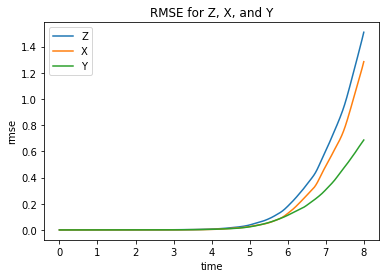

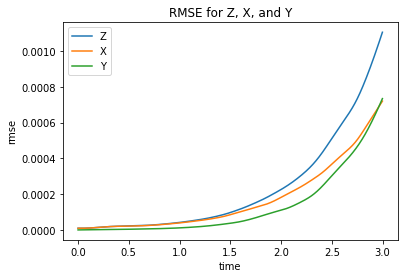

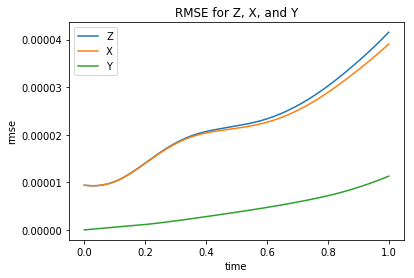

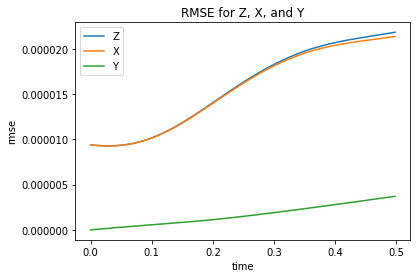

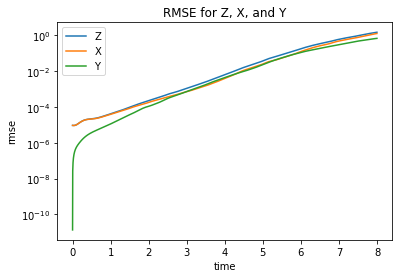

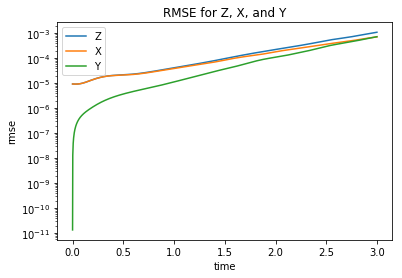

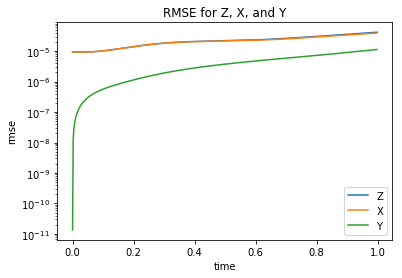

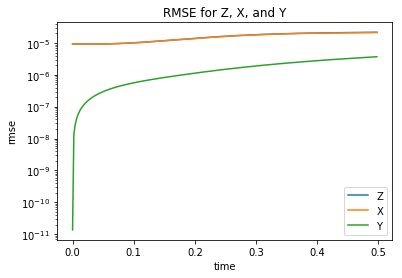

In [13]:
time = 8
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.5
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 8
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.5
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

Text(0.5, 1.0, 'RMSE for Y')

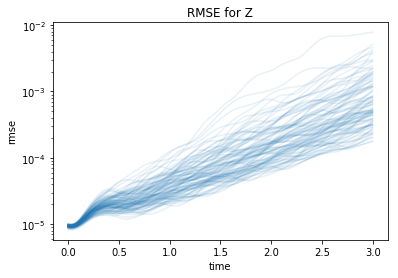

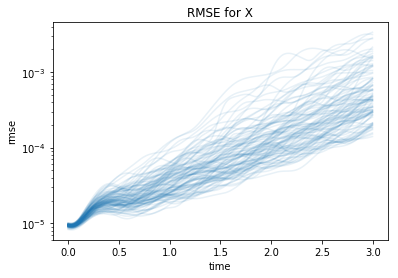

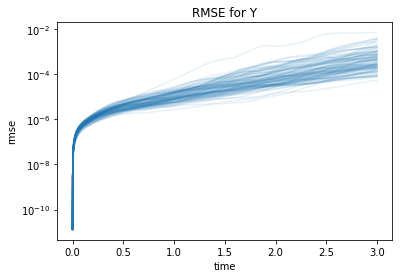

In [14]:
time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:, :this_index].T, color='C0', alpha=0.1)
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], X_ave_rmse[:, :this_index].T, color='C0', alpha=0.1)
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for X')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:, :this_index].T, color='C0', alpha=0.1)
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Y')

In [15]:
# for identity

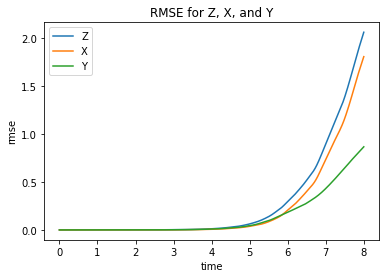

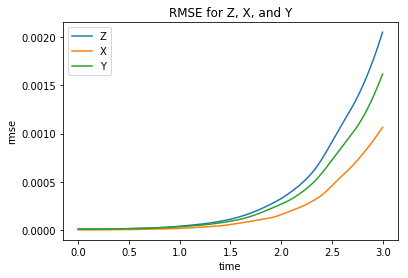

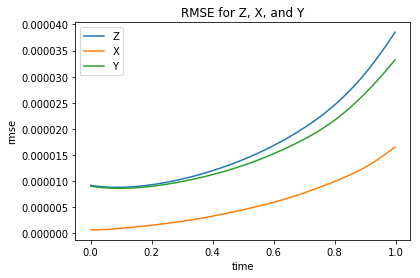

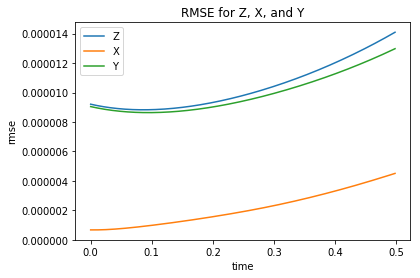

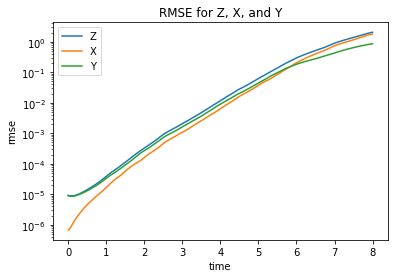

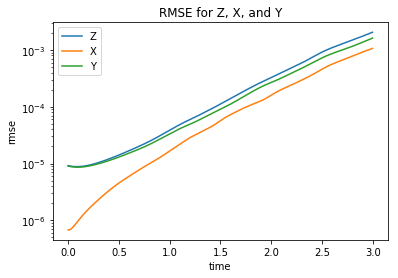

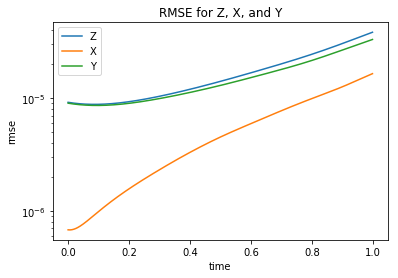

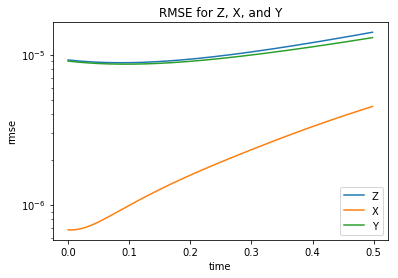

In [21]:
time = 8
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.5
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.plot(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.plot(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 8
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 1
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

time = 0.5
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Zc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Xc_ave_rmse[:this_index])
plt.semilogy(t_gt[:this_index], Yc_ave_rmse[:this_index])
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z, X, and Y')
plt.legend(['Z', 'X', 'Y'])

Text(0.5, 1.0, 'RMSE for Y')

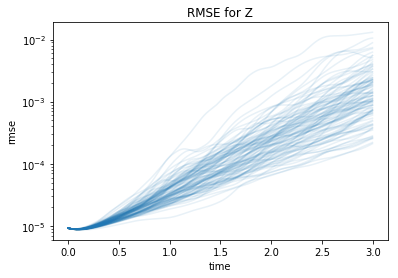

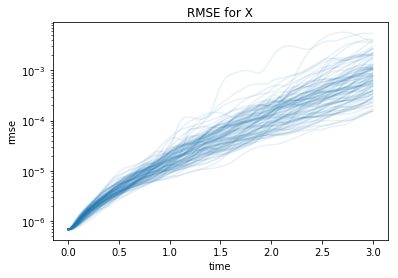

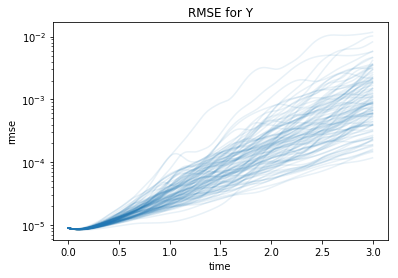

In [22]:
time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Z_ave_rmse[:, :this_index].T, color='C0', alpha=0.1)
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Z')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], X_ave_rmse[:, :this_index].T, color='C0', alpha=0.1)
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for X')

time = 3
this_index = np.abs(t_gt - time).argmin()
plt.figure()
plt.semilogy(t_gt[:this_index], Y_ave_rmse[:, :this_index].T, color='C0', alpha=0.1)
plt.ylabel('rmse')
plt.xlabel('time')
plt.title('RMSE for Y')